# Кейс №1 - Приложение знакомств.
Оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого выберем метрики, которые отвечают за качество сервиса, и статистически сравним эти метрики в двух группах. Наша главная задача заключается в том, чтобы у пользователей случалось больше мэтчей. Поэтому в качестве целевой метрики возьмем мэтч рейт, который высчитывается как отношение количества мэтчей у пользователя к общему количеству свайпов (т.е. возможных пар с этим пользователем, для упрощения будем называть свайпами). В качестве прокси-метрики возьмем показатель свайпов на пользователя (стали ли пользователи впринципе больше свайпать - охотнее искать пару).

### Этапы работы:
1. Выгрузка и предобработка данных.
2. Анализ целевой метрики.
3. Анализ прокси-метрики.
4. Выводы.

### Этап 1. Выгрузка и предобработка данных.

In [1]:
# Импортируем требующиеся библиотеки.
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Устанавливаем масштаб графиков и шрифта.
sns.set(rc = {'figure.figsize':(12, 8)})

In [3]:
# Считываем данные.
data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-belyj/A_B_tests/dating_data.csv')
data.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


Пользователь может встречаться как в колонке 'user_id_1', так и в колонке 'user_id_2'. Чтобы учесть все свайпы пользователей, соорудим одну общую колонку для каждого свайпа каждого пользователя (все остальные данные так же не забываем перенести).

In [4]:
# Отбираем нужные срезы из датафрейма.
temp_1 = data[['user_id_1', 'group', 'is_match']].rename(columns={'user_id_1':'user_id'})
temp_2 = data[['user_id_2', 'group', 'is_match']].rename(columns={'user_id_2':'user_id'})

In [5]:
# Складываем срезы, добавляем колонку с единицей (показывает что строка-1 свайп).
result = pd.concat([temp_1, temp_2])
result['counter'] = 1

In [6]:
# Группируем по пользователю и находим количество мэтчей, общее количество свайпов и мэтч рейт.
result = result.groupby(['user_id', 'group'], as_index=False) \
               .agg({'is_match':'sum', 'counter':'sum'}) \
               .assign(match_rate = lambda x: x.is_match / x.counter)
result

,user_id,group,is_match,counter,match_rate
0,1,1,16,37,0.432432
1,2,1,16,39,0.410256
2,3,1,8,25,0.320000
3,4,0,3,17,0.176471
4,5,1,18,34,0.529412
...,...,...,...,...,...
995,996,0,2,14,0.142857
996,997,0,1,26,0.038462
997,998,1,18,36,0.500000
998,999,0,3,20,0.150000


### Этап 2. Анализ целевой метрики.

Гипотезы для целевой метрики:
<ul>
<li>H_0 - Мэтч рейт в тестовой группе относительно мэтч рейта в контрольной группе не изменился.
<li>H_1 - Мэтч рейт в тестовой группе относительно мэтч рейта в контрольной группе изменился.

In [7]:
# Описательная статистика для мэтч рейта в контрольной группе.
result[result.group == 0].match_rate.describe()

count    501.000000
mean       0.193549
std        0.090739
min        0.000000
25%        0.130435
50%        0.190476
75%        0.250000
max        0.500000
Name: match_rate, dtype: float64

In [8]:
# Описательная статистика для мэтч рейта в тестовой группе.
result[result.group == 1].match_rate.describe()

count    499.000000
mean       0.402271
std        0.081631
min        0.119048
25%        0.342481
50%        0.404762
75%        0.454545
max        0.714286
Name: match_rate, dtype: float64

Среднее значение в тестовой группе выше, чем в контрольной. Если различия признаем статистически значимыми, то новый алгоритм для поиска анкет положительно повлиял на мэтч рейт, а значит сделал приложение лучше.

Посмотрим на распределение мэтч рейта по нашим группам, проверим, однородны ли дисперсии в наших выборках и решим, какой статистический критерий применить.

In [9]:
# Берем показатели мэтч рейта в виде одномерных массивов.
sample_control = np.array(result[result.group == 0].match_rate)
sample_test = np.array(result[result.group == 1].match_rate)

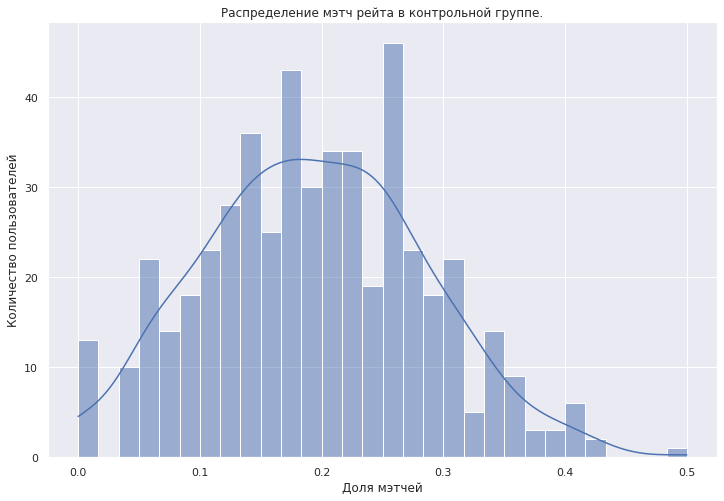

In [10]:
# Изобразим распределение мэтч рейта в контрольной группе.
sns.histplot(data=result[result.group == 0], x='match_rate', kde=True, bins = 30);
plt.xlabel('Доля мэтчей')
plt.ylabel('Количество пользователей')
plt.title('Распределение мэтч рейта в контрольной группе.');

In [11]:
# Проверим распределение на нормальность.
stats.shapiro(sample_control)
# P-value меньше 0.05 => выборка не происходит из нормального распределения.

ShapiroResult(statistic=0.9935588240623474, pvalue=0.031214840710163116)

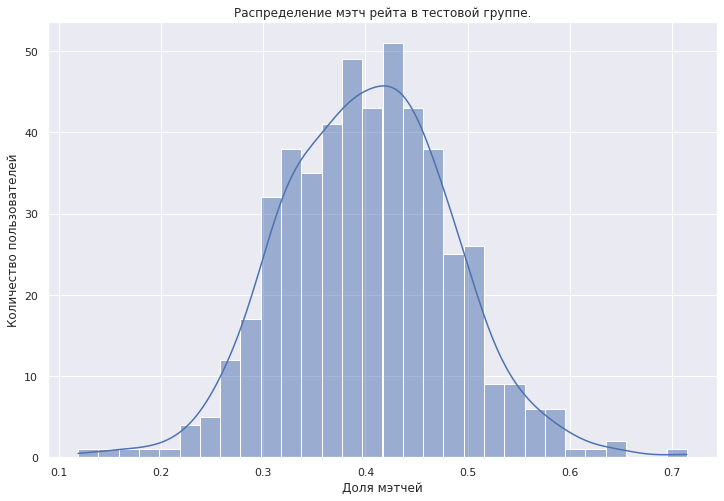

In [12]:
# Изобразим распределение мэтч рейта в тестовой группе.
sns.histplot(data=result[result.group == 1], x='match_rate', kde=True, bins = 30);
plt.xlabel('Доля мэтчей')
plt.ylabel('Количество пользователей')
plt.title('Распределение мэтч рейта в тестовой группе.');

In [13]:
# Проверим распределение на нормальность.
stats.shapiro(sample_test)
# P-value больше 0.05 => выборка происходит из нормального распределения.

ShapiroResult(statistic=0.996323823928833, pvalue=0.30635735392570496)

In [14]:
# Количество пользователей по группам.
result.group.value_counts()

0    501
1    499
Name: group, dtype: int64

In [15]:
# Смотрим на однородность дисперсий в выборках.
stats.levene(sample_control, sample_test)
# P-value меньше 0.05 => отклоняем нулевую гипотезу о равенстве дисперсий.

LeveneResult(statistic=7.013821816267975, pvalue=0.008215929686873376)

Итого:
<ul>
<li>Признак в контрольной выборке распределен не нормально, признак в тестовой выборке распределен нормально.
<li>Количество наблюдений в выборках практически равно и большое (сильно больше 30).
<li>Дисперсии в выборках не однородны.
<ul>

В связи со всем вышесказанным в качестве статистического критерия воспользуемся T-тестом с параметром equal_var=False (T-тест Уэлча, который учитывает неоднородность дисперсий в выборках).

In [16]:
# Применяем T-тест.
stats.ttest_ind(sample_control, sample_test, equal_var=False)

Ttest_indResult(statistic=-38.24265817843151, pvalue=4.415153883535013e-197)

P-value < 0.05, значит отклоняем нулевую гипотезу о равенстве средних значений мэтч рейта. При этом, мэтч рейт в тестовой группе по сравнению с контрольной статистически значимо увеличился.

### Этап 3. Анализ прокси-метрики.

Гипотезы для прокси-метрики:
<ul>
<li>H_0 - Количество свайпов в тестовой группе относительно количества свайпов в контрольной группе не изменилось.
<li>H_1 - Количество свайпов в тестовой группе относительно количества свайпов в контрольной группе изменилось.

In [28]:
result

,user_id,group,is_match,counter,match_rate
0,1,1,16,37,0.432432
1,2,1,16,39,0.410256
2,3,1,8,25,0.320000
3,4,0,3,17,0.176471
4,5,1,18,34,0.529412
...,...,...,...,...,...
995,996,0,2,14,0.142857
996,997,0,1,26,0.038462
997,998,1,18,36,0.500000
998,999,0,3,20,0.150000


In [29]:
# Описательная статистика для количества свайпов в контрольной группе.
result[result.group == 0].counter.describe()

count    501.000000
mean      19.129741
std        4.426865
min        8.000000
25%       16.000000
50%       19.000000
75%       22.000000
max       34.000000
Name: counter, dtype: float64

In [30]:
# Описательная статистика для количества свайпов в тестовой группе.
result[result.group == 1].counter.describe()

count    499.000000
mean      38.965932
std        5.499986
min       22.000000
25%       35.000000
50%       39.000000
75%       43.000000
max       54.000000
Name: counter, dtype: float64

Медиана в тестовой группе выше, чем в контрольной. Если различия признаем статистически значимыми, то новый алгоритм для поиска анкет положительно повлиял на количество свайпов для каждого пользователя, а значит сделал приложение лучше.

Посмотрим на распределение количества свайпов по нашим группам, проверим, однородны ли дисперсии в наших выборках и решим, какой статистический критерий применить.

In [31]:
# Берем показатели количества свайпов в виде одномерных массивов.
sample_control_proxy = np.array(result[result.group == 0].counter)
sample_test_proxy = np.array(result[result.group == 1].counter)

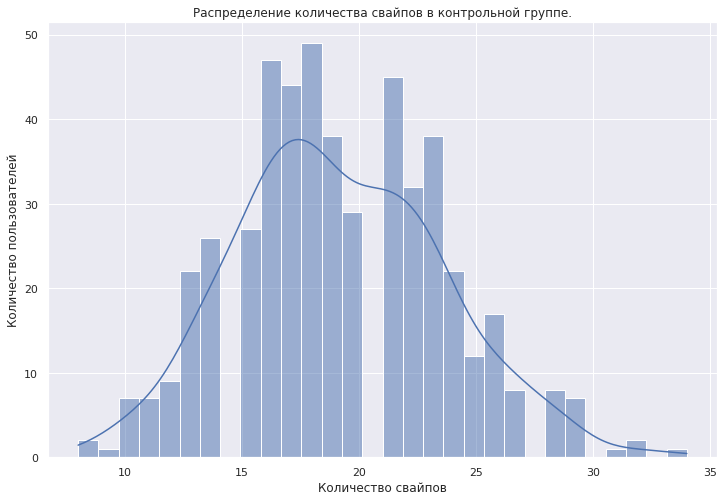

In [32]:
# Изобразим распределение количества свайпов в контрольной группе.
sns.histplot(data=result[result.group == 0], x='counter', kde=True, bins = 30);
plt.xlabel('Количество свайпов')
plt.ylabel('Количество пользователей')
plt.title('Распределение количества свайпов в контрольной группе.');

In [33]:
# Проверим распределение на нормальность.
stats.shapiro(sample_control_proxy)
# P-value меньше 0.05 => выборка не происходит из нормального распределения.

ShapiroResult(statistic=0.9900698661804199, pvalue=0.0018430245108902454)

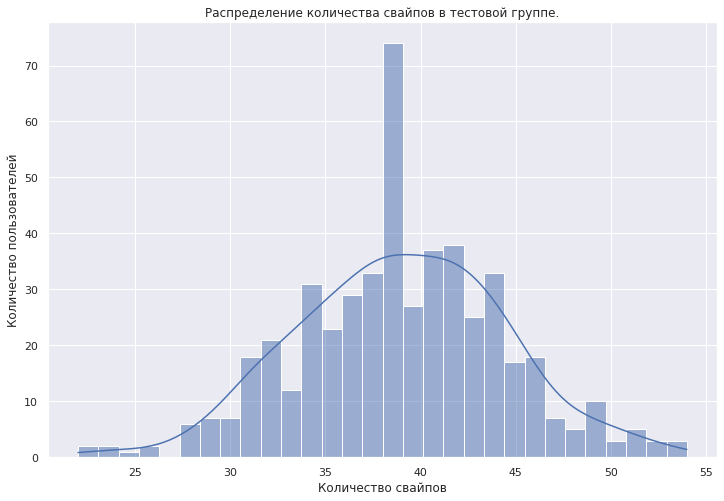

In [34]:
# Изобразим распределение количества свайпов в тестовой группе.
sns.histplot(data=result[result.group == 1], x='counter', kde=True, bins = 30);
plt.xlabel('Количество свайпов')
plt.ylabel('Количество пользователей')
plt.title('Распределение количества свайпов в тестовой группе.');

In [35]:
# Проверим распределение на нормальность.
stats.shapiro(sample_test_proxy)
# P-value больше 0.05 => выборка происходит из нормального распределения.

ShapiroResult(statistic=0.9948619604110718, pvalue=0.09494461119174957)

In [25]:
# Смотрим на однородность дисперсий в выборках.
stats.levene(sample_control_proxy, sample_test_proxy)
# P-value меньше 0.05 => отклоняем нулевую гипотезу о равенстве дисперсий.

LeveneResult(statistic=18.48241338729555, pvalue=1.8829191577883398e-05)

Итого:
<ul>
<li>Признак в контрольной выборке распределен не нормально, признак в тестовой выборке распределен нормально.
<li>Количество наблюдений в выборках практически равно и большое (сильно больше 30).
<li>Дисперсии в выборках не однородны.
<ul>

В связи со всем вышесказанным в качестве статистического критерия воспользуемся Bootstrap и сравним медианы выборок.

In [26]:
# Применяем Bootstrap к контрольной группе.
stats.bootstrap((result[result.group == 0].counter, ), statistic = np.median, method = 'percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=18.0, high=19.0), standard_error=0.40617763451675803)

In [27]:
# Применяем Bootstrap к тестовой группе.
stats.bootstrap((result[result.group == 1].counter, ), statistic = np.median, method = 'percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=38.0, high=40.0), standard_error=0.29759023205183477)

Доверительные интервалы медианных значений не пересекаются, значит отклоняем нулевую гипотезу о равенстве медианных значений количества свайпов. При этом, количество свайпов в тестовой группе по сравнению с контрольной статистически значимо увеличилось.

### Этап 4. Выводы.

Мы провели анализ данных, проверили гипотезы и выяснили, что мэтч рейт в тестовой группе статистически значимо отличается в положительную сторону от мэтч рейта в контрольной группе, что улучшает качество приложения. Так же мы выяснили, что пользователи в целом стали больше свайпать (количество свайпов в тестовой группе статистически значимо отличается в положительную сторону от количества свайпов в контрольной группе), что так же улучшает качество приложения. 
##### В связи со всем выше сказанным, в заключении я скажу, что стоит включать новую систему поиска анкет на всех пользователей, так как были найдены статистически значимые положительные различия по целевой метрике и прокси-метрике в контрольной и тестовой группах.